In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold

from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Считываем данные и разбиваем их на тренировочную и тестовую выборки

In [2]:
with open('data_for_models.csv') as f:
    data = pd.read_csv(f)

In [3]:
numeric_cols = data.select_dtypes(include='number').columns.tolist() # оставляю только числовые столбцы

data = data.astype({
    col: 'int64' for col in numeric_cols 
})


In [4]:
data = data.drop(columns = ['serial_number', 'date'])

In [5]:
random_state = 2025 # нужен для повторяемости результатов

# pos_data = data.query("target == 1")

# # оставляем только 33% случайных сэмплов класса 0 для каждого диска
# neg_data = (
#     data
#     .query("target == 0")
#     .groupby("serial_number", as_index=False)
#     .apply(lambda x: x.sample(frac=0.33, random_state=random_state))
#     .reset_index(drop=True)
# )

# # новый датасет
# data = pd.concat((neg_data, pos_data), axis=0)

In [6]:
from imblearn.under_sampling import NearMiss

# NearMiss-1 (параметр version=1 по умолчанию)
nm = NearMiss(sampling_strategy=0.1, version=1)

original_indices = data.index

# Преобразование данных
X_resampled, y_resampled = nm.fit_resample(data.drop(columns=['target']), data['target'])

removed_indices = original_indices.difference(X_resampled.index)
removed_data = data.loc[removed_indices]

# Собираем новый датафрейм
data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['target'])], axis=1)

In [7]:
# data = data.drop(columns = ['serial_number', 'date'])
# data = data.drop(columns = ['smart_5_diff',	'smart_187_diff',	'smart_198_diff',	'smart_199_max'
#                           ])

In [8]:
data

,smart_5_last,smart_9_last,smart_187_last,smart_188_last,smart_192_last,smart_198_last,smart_199_last,smart_240_last,smart_241_last,smart_242_last,block,smart_5_diff,smart_187_diff,smart_198_diff,smart_199_max,AUC_smart_5_raw,AUC_smart_187_raw,AUC_smart_198_raw,target
0,0,3406,0,0,0,0,0,2939,39492431280,55112235828,5,0,0,0,0,0,0,0,0
1,0,9623,0,0,0,0,0,9126,69413224320,155346391960,13,0,0,0,0,0,0,0,0
2,0,9723,0,0,1,0,0,9247,69469446704,155353376982,13,0,0,0,0,0,0,0,0
3,0,9601,0,0,0,0,0,9124,69363990976,155287394232,13,0,0,0,0,0,0,0,0
4,0,9620,0,0,0,0,0,9126,69287338328,155356778028,13,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,0,15943,820,4295032833,16,0,0,15527,87198911944,233614901482,22,0,0,0,0,0,23780,0,1
1844,0,13306,0,0,3,0,0,13086,83943199456,204123480846,19,0,0,0,0,0,0,0,1
1845,0,7243,18,0,0,96,0,6840,58561660336,88530467778,10,0,10,32,0,0,327,2160,1
1846,0,6186,0,0,0,0,0,5797,55168531248,74917161090,9,0,0,0,0,0,0,0,1


In [9]:
# Т.к. нам нужно, чтобы в тестовой выборки с реальными данными не осталось 2-3 экземпляра класса 1 - проведём следующее разделение

# Разделяем данные класса 1 и класса 0
class_1 = data[data['target'] == 1]
class_0 = data[data['target'] == 0]

# Фиксируем N% объектов класса 1 для тестовой выборки (можно попробовать взять меньше - больше)
class_1_train, class_1_test = train_test_split(class_1, test_size=0.1, random_state=random_state)

# Добавляем пропорциональное количество данных класса 0
class_0_train, class_0_test = train_test_split(class_0, test_size=0.1, random_state=random_state)

# Собираем тренировочные и тестовые выборки
train_data = pd.concat([class_1_train, class_0_train])
test_data = pd.concat([class_1_test, class_0_test])

removed_data = pd.concat([removed_data, class_1_test])

# Перемешиваем данные
train_data = train_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

removed_data = removed_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Разделяем на X и y для обучения и теста
X_train, y_train = train_data.drop(columns=['target']), train_data['target']
X_test, y_test = test_data.drop(columns=['target']), test_data['target']

removed_data_x_test, removed_data_y_test = removed_data.drop(columns=['target']), removed_data['target']

## Отдельное обучение одной модели

In [11]:
# Определение модели и кросс-валидации
clf = RandomForestClassifier(random_state=random_state)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Заводим массив для метрик кросс-валидации
roc_auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Кросс-валидация с балансировкой данных с помощью SMOTEENN
for train_idx, val_idx in tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc="Cross-validation"):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    smote_enn = SMOTEENN(random_state=random_state)
    X_resampled, y_resampled = smote_enn.fit_resample(X_fold_train, y_fold_train)
    
    # Обучение модели на синтетических данных
    clf.fit(X_resampled, y_resampled)
    
    # Оценка на валидационной выборке (реальные данные)
    y_val_pred = clf.predict(X_fold_val)
    y_val_pred_proba = clf.predict_proba(X_fold_val)[:, 1]
    
    # Расчёт метрик
    roc_auc = roc_auc_score(y_fold_val, y_val_pred_proba)
    precision = precision_score(y_fold_val, y_val_pred)
    recall = recall_score(y_fold_val, y_val_pred)
    f1 = f1_score(y_fold_val, y_val_pred)
    
    roc_auc_scores.append(roc_auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Вывод метрик кросс-валидации
print(f"Средний ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
print(f"Средний Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Средний Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"Средний F1-Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# Финальное тестирование на реальных данных
smote_enn = SMOTEENN(random_state=random_state)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

clf.fit(X_resampled, y_resampled)

y_test_pred = clf.predict(X_test)
y_test_pred_proba = clf.predict_proba(X_test)[:, 1]

print("\nКлассификационный отчет на тестовых данных (реальные данные):")
print(classification_report(y_test, y_test_pred, digits=4))

print(f"ROC-AUC на тестовых данных: {roc_auc_score(y_test, y_test_pred_proba):.4f}")
print(f"Precision на тестовых данных: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall на тестовых данных: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score на тестовых данных: {f1_score(y_test, y_test_pred):.4f}")

Cross-validation: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Средний ROC-AUC: 0.9814 ± 0.0082
Средний Precision: 0.7528 ± 0.0251
Средний Recall: 0.8017 ± 0.0803
Средний F1-Score: 0.7740 ± 0.0357

Классификационный отчет на тестовых данных (реальные данные):
              precision    recall  f1-score   support

           0     1.0000    0.9702    0.9849       168
           1     0.7727    1.0000    0.8718        17

    accuracy                         0.9730       185
   macro avg     0.8864    0.9851    0.9283       185
weighted avg     0.9791    0.9730    0.9745       185

ROC-AUC на тестовых данных: 0.9974
Precision на тестовых данных: 0.7727
Recall на тестовых данных: 1.0000
F1-Score на тестовых данных: 0.8718


## Обучение сразу нескольких моделей


Обучение модели: Logistic Regression


Logistic Regression CV: 100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


Вычисление SHAP для модели: Logistic Regression


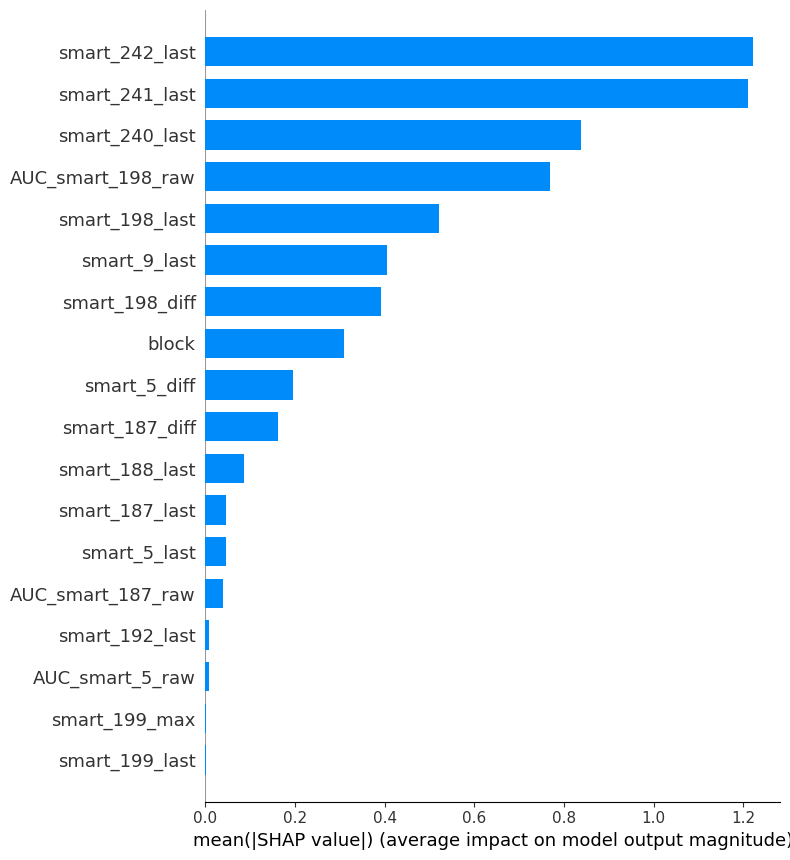


Обучение модели: Random Forest


Random Forest CV: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Вычисление SHAP для модели: Random Forest


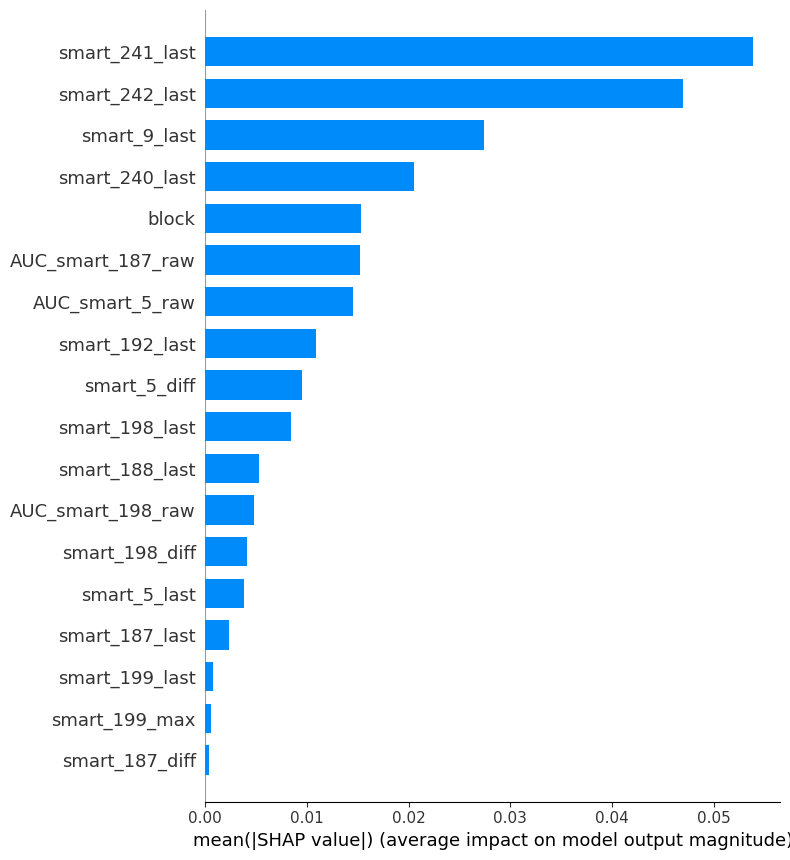


Обучение модели: Extra Trees


Extra Trees CV: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


Вычисление SHAP для модели: Extra Trees


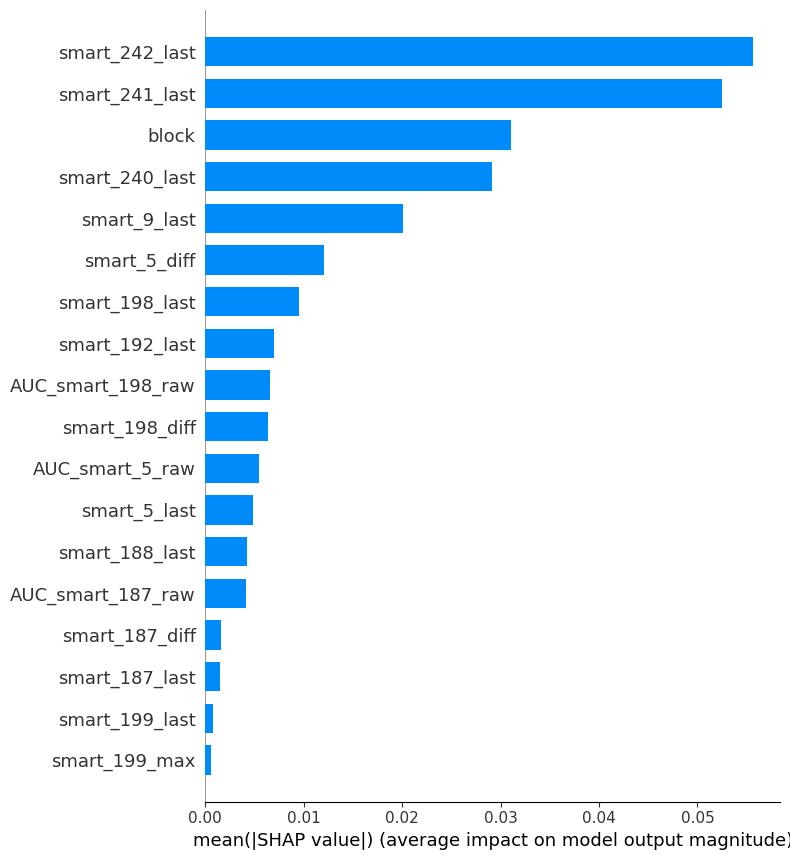


Обучение модели: LightGBM


LightGBM CV:  20%|██        | 1/5 [00:00<00:01,  3.21it/s]

[LightGBM] [Info] Number of positive: 1057, number of negative: 1045
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2466
[LightGBM] [Info] Number of data points in the train set: 2102, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502854 -> initscore=0.011418
[LightGBM] [Info] Start training from score 0.011418


LightGBM CV:  40%|████      | 2/5 [00:00<00:00,  3.81it/s]

[LightGBM] [Info] Number of positive: 1035, number of negative: 994
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2337
[LightGBM] [Info] Number of data points in the train set: 2029, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.510103 -> initscore=0.040419
[LightGBM] [Info] Start training from score 0.040419


LightGBM CV:  60%|██████    | 3/5 [00:00<00:00,  4.25it/s]

[LightGBM] [Info] Number of positive: 1049, number of negative: 1019
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2609
[LightGBM] [Info] Number of data points in the train set: 2068, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507253 -> initscore=0.029016
[LightGBM] [Info] Start training from score 0.029016
[LightGBM] [Info] Number of positive: 1063, number of negative: 1028
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2502
[LightGBM] [Info] Number of data points in the train set: 2091, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508369 -> initscore=0.033480
[LightGBM] [Info] Start training from score 0.033480
[LightGBM] [Warning] N

LightGBM CV: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]

[LightGBM] [Info] Number of positive: 1053, number of negative: 1001
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2358
[LightGBM] [Info] Number of data points in the train set: 2054, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512658 -> initscore=0.050644
[LightGBM] [Info] Start training from score 0.050644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Number of positive: 1308, number of negative: 1211
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2839
[LightGBM] [Info] Number of data points in the train set: 2519, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.519254 -> initscore=0.077053
[LightGBM] [Info] Start training from score 0.077053
Вычисление SHAP для модели: LightGBM


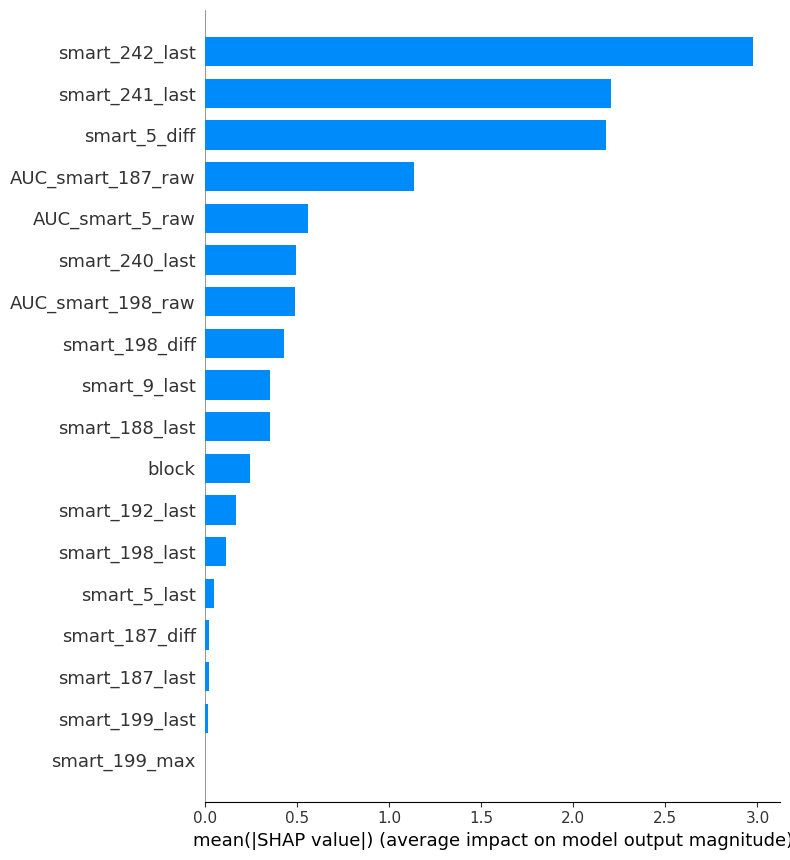


Обучение модели: CatBoost


CatBoost CV: 100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


Вычисление SHAP для модели: CatBoost


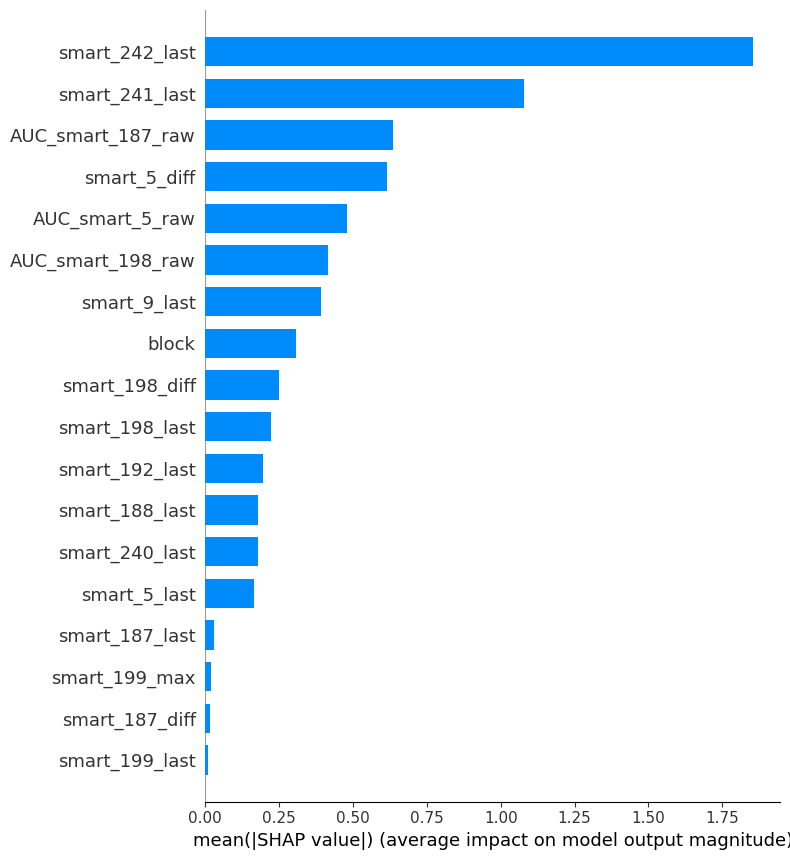


Обучение модели: XGBoost


XGBoost CV: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Вычисление SHAP для модели: XGBoost


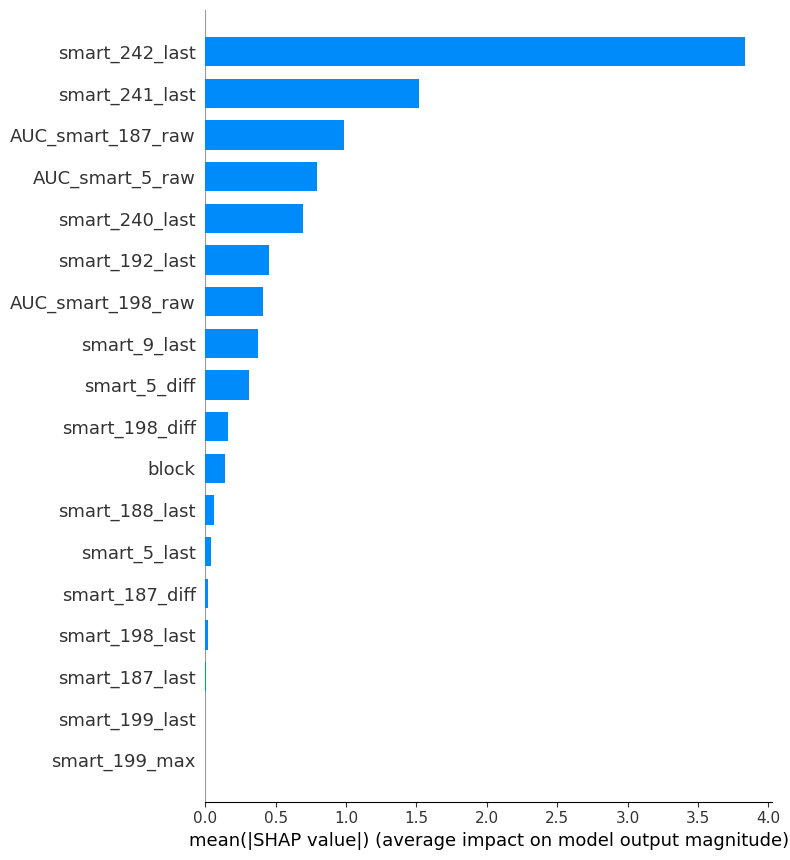


Результаты моделей:


,Model,ROC-AUC (CV),Precision (CV),Recall (CV),F1-Score (CV),ROC-AUC (Test),Precision (Test),Recall (Test),F1-Score (Test),ROC-AUC (Removed Data),Precision (Removed Data),Recall (Removed Data),F1-Score (Removed Data)
0,Logistic Regression,0.8507 ± 0.0404,0.8105 ± 0.1213,0.6032 ± 0.0958,0.6790 ± 0.0614,0.9300,0.7500,0.7059,0.7273,0.7009,0.0012,0.6595,0.0025
1,Random Forest,0.9814 ± 0.0082,0.7528 ± 0.0251,0.8017 ± 0.0803,0.7740 ± 0.0357,0.9974,0.7727,1.0000,0.8718,0.7425,0.0010,0.9514,0.0021
2,Extra Trees,0.9823 ± 0.0066,0.7996 ± 0.0409,0.8413 ± 0.0480,0.8193 ± 0.0383,0.9993,0.7391,1.0000,0.8500,0.8008,0.0010,0.9459,0.0019
3,LightGBM,0.9770 ± 0.0112,0.8142 ± 0.0363,0.8409 ± 0.0683,0.8262 ± 0.0443,0.9933,0.7500,0.8824,0.8108,0.7448,0.0009,0.9243,0.0019
4,CatBoost,0.9742 ± 0.0107,0.8150 ± 0.0463,0.8080 ± 0.0771,0.8095 ± 0.0490,0.9944,0.6957,0.9412,0.8000,0.7758,0.0010,0.9351,0.0020
5,XGBoost,0.9700 ± 0.0159,0.8089 ± 0.0490,0.8409 ± 0.0775,0.8234 ± 0.0583,0.9968,0.7619,0.9412,0.8421,0.7755,0.0010,0.9297,0.0019


In [12]:
# Определение моделей
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()), 
        ('classifier', LogisticRegression(random_state=random_state, max_iter=1000, class_weight="balanced"))
    ]),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Extra Trees": ExtraTreesClassifier(random_state=random_state),
    "LightGBM": LGBMClassifier(random_state=random_state),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=random_state),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=random_state)
}

# Определение кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Массив для хранения результатов метрик по каждой моделей
results = []

# Обучение для каждой модели
for model_name, model in models.items():
    print(f"\nОбучение модели: {model_name}")
    roc_auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Кросс-валидация с балансировкой данных с помощью SMOTEENN
    for train_idx, val_idx in tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc=f"{model_name} CV"):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        smote_enn = SMOTEENN(random_state=random_state)
        X_resampled, y_resampled = smote_enn.fit_resample(X_fold_train, y_fold_train)

        # Обучение модели на синтетических данных
        model.fit(X_resampled, y_resampled)

        # Оценка на валидационной выборке (реальные данные)
        y_val_pred = model.predict(X_fold_val)
        y_val_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        roc_auc = roc_auc_score(y_fold_val, y_val_pred_proba)
        precision = precision_score(y_fold_val, y_val_pred)
        recall = recall_score(y_fold_val, y_val_pred)
        f1 = f1_score(y_fold_val, y_val_pred)

        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Сохранение средних значений метрик
    results.append({
        "Model": model_name,
        "ROC-AUC (CV)": f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}",
        "Precision (CV)": f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
        "Recall (CV)": f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
        "F1-Score (CV)": f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}"
    })

    # Финальное тестирование на реальных данных
    smote_enn = SMOTEENN(random_state=random_state)
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
    model.fit(X_resampled, y_resampled)

    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    test_metrics = {
        "ROC-AUC (Test)": roc_auc_score(y_test, y_test_pred_proba),
        "Precision (Test)": precision_score(y_test, y_test_pred),
        "Recall (Test)": recall_score(y_test, y_test_pred),
        "F1-Score (Test)": f1_score(y_test, y_test_pred)
    }

    # Добавление тестовых метрик в финальные результаты
    results[-1].update({key: f"{value:.4f}" for key, value in test_metrics.items()})

    # Построение ROC и PR кривых
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_pred_proba)

    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure(figsize=(12, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='b')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, label=f'AUC = {pr_auc:.2f}', color='g')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')

    # Сохранение графиков
    plt.suptitle(f'{model_name} - ROC and PR Curves')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"results/resempled/{model_name}_ROC_PR_Curves.png")
    plt.close()


    if model_name != "Logistic Regression":
        # Вычисление SHAP-значений
        print(f"Вычисление SHAP для модели: {model_name}")
        if model_name in ["Random Forest", "Extra Trees"]:
            explainer = shap.Explainer(model, X_train)
        elif model_name in ["LightGBM", "CatBoost", "XGBoost"]:
            explainer = shap.TreeExplainer(model)
        else:
            continue

        shap_values = explainer(X_test)

        # Визуализация SHAP для модели
        if len(shap_values.shape) == 3:  
            shap_values_class_1 = shap_values[..., 1]  
        else:
            shap_values_class_1 = shap_values 

        shap.summary_plot(shap_values_class_1, X_test, plot_type="bar")

    else:
        print(f"Вычисление SHAP для модели: {model_name}")
        if isinstance(model, Pipeline):
            base_model = model.named_steps['classifier']
            explainer = shap.Explainer(base_model, model.named_steps['scaler'].transform(X_train), feature_names=X_train.columns)

        shap_values = explainer(model.named_steps['scaler'].transform(X_test) if isinstance(model, Pipeline) else X_test)

        # Визуализация SHAP для модели
        shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)

    # Данные, которые модель не видела (проверим класс 0)
    y_test_pred = model.predict(removed_data_x_test)
    y_test_pred_proba = model.predict_proba(removed_data_x_test)[:, 1]

    test_metrics = {
        "ROC-AUC (Removed Data)": roc_auc_score(removed_data_y_test, y_test_pred_proba),
        "Precision (Removed Data)": precision_score(removed_data_y_test, y_test_pred),
        "Recall (Removed Data)": recall_score(removed_data_y_test, y_test_pred),
        "F1-Score (Removed Data)": f1_score(removed_data_y_test, y_test_pred),
    }

    # Добавление тестовых метрик в финальные результаты
    results[-1].update({key: f"{value:.4f}" for key, value in test_metrics.items()})


# Вывод таблицы результатов
results_df = pd.DataFrame(results)

print("\nРезультаты моделей:")
results_df

In [13]:
results_df.to_csv("results/models_results_resampled.csv", index=False)

## Обучение с помощью балансировки весов классов (class_weight)


Обучение модели: Logistic Regression


Logistic Regression CV:   0%|          | 0/5 [00:00<?, ?it/s]

Logistic Regression CV: 100%|██████████| 5/5 [00:00<00:00, 23.92it/s]


Вычисление SHAP для модели: Logistic Regression


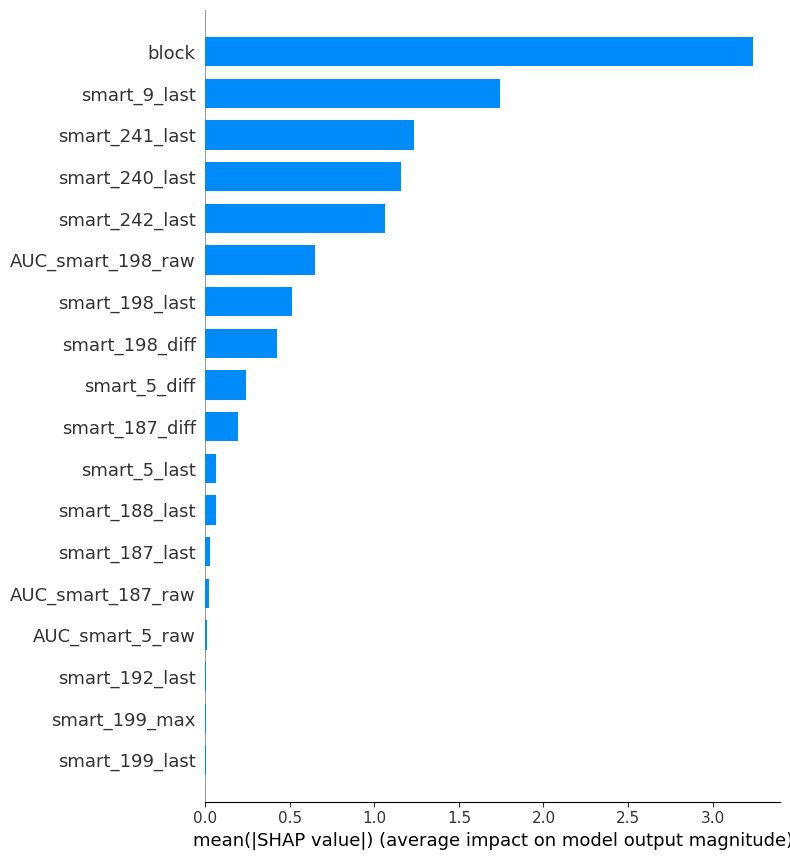


Обучение модели: Random Forest


Random Forest CV: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Вычисление SHAP для модели: Random Forest


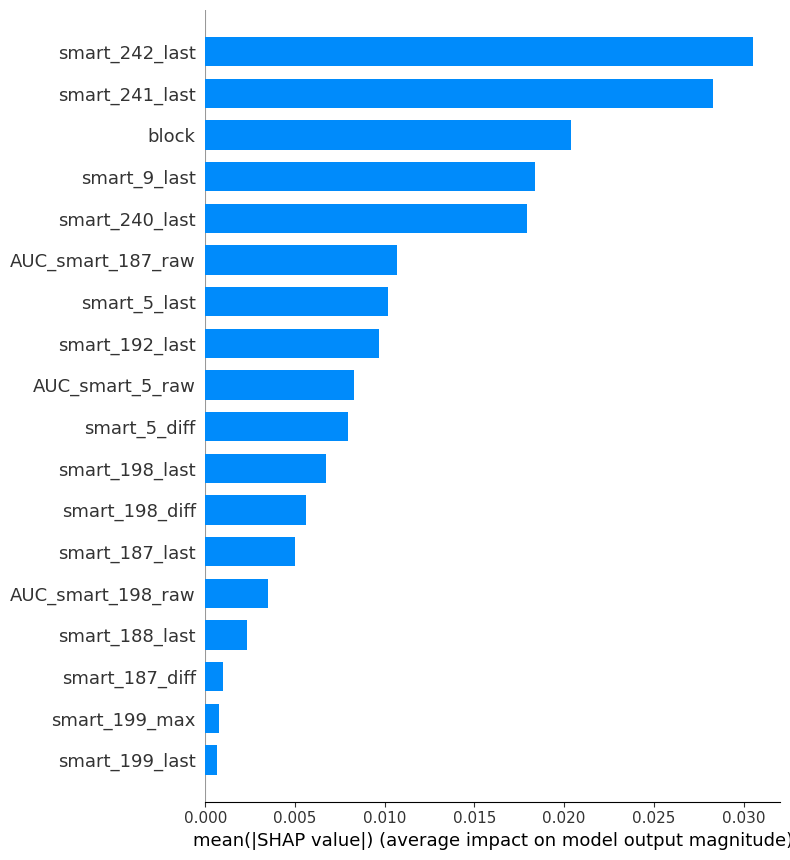


Обучение модели: LightGBM


LightGBM CV:  40%|████      | 2/5 [00:00<00:00, 13.45it/s]

[LightGBM] [Info] Number of positive: 121, number of negative: 1209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1225
[LightGBM] [Info] Number of data points in the train set: 1330, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 121, number of negative: 1209
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1209
[LightGBM] [Info] Num

LightGBM CV: 100%|██████████| 5/5 [00:00<00:00, 13.21it/s]

[LightGBM] [Info] Number of positive: 121, number of negative: 1210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 1331, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 121, number of negative: 1210
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1211
[LightGBM] [Info] Number of data points in the train set: 1331, number of used features: 18
[Lig

Вычисление SHAP для модели: LightGBM


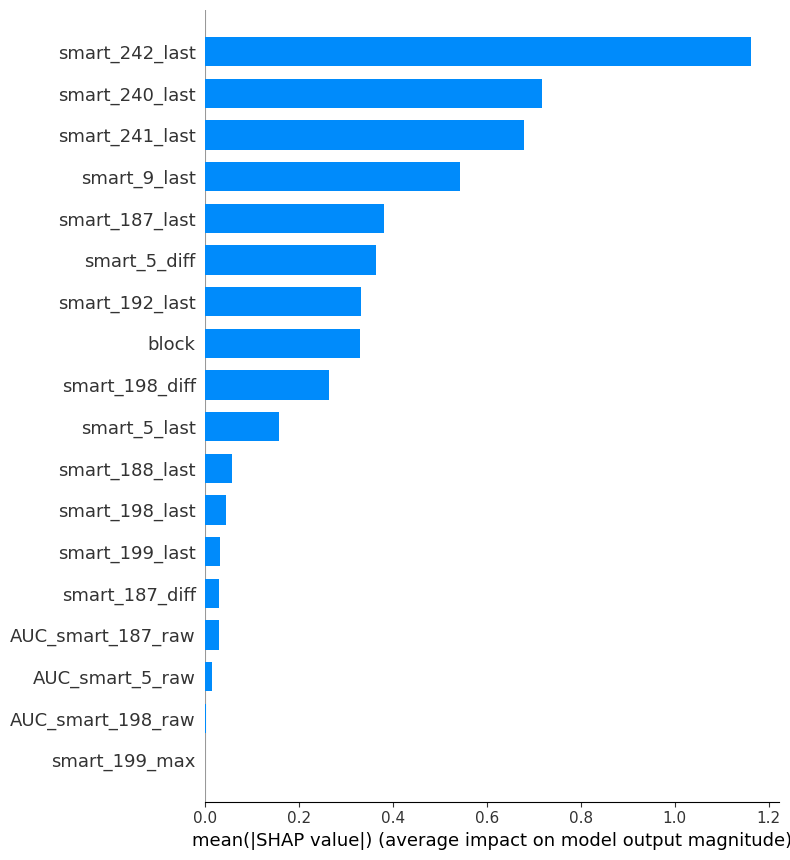


Обучение модели: Extra Trees


Extra Trees CV: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


Вычисление SHAP для модели: Extra Trees


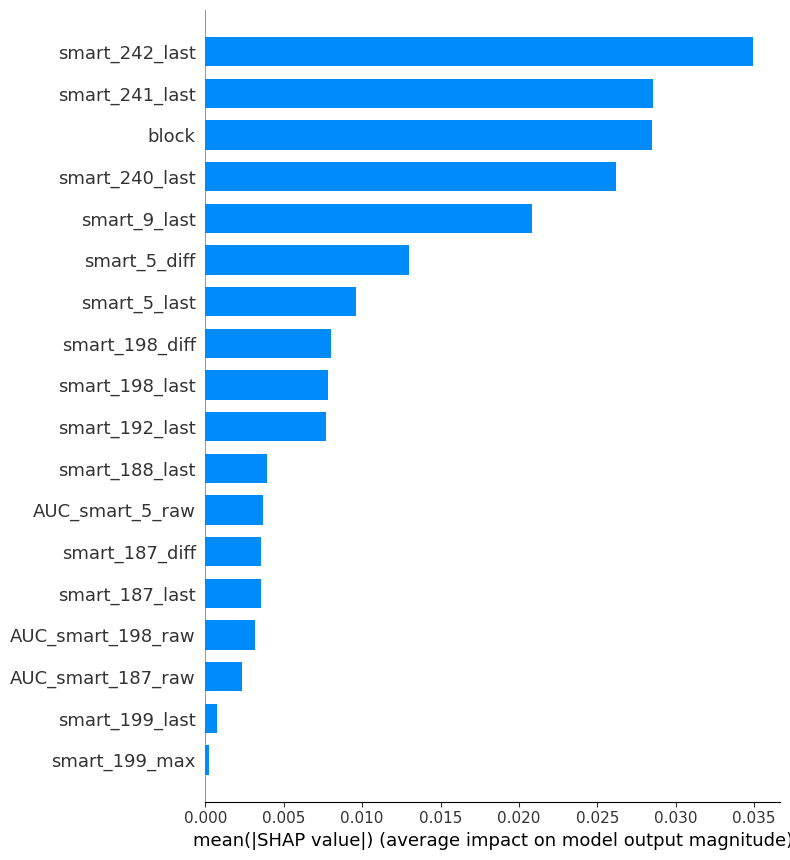


Обучение модели: CatBoost


CatBoost CV: 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


Вычисление SHAP для модели: CatBoost


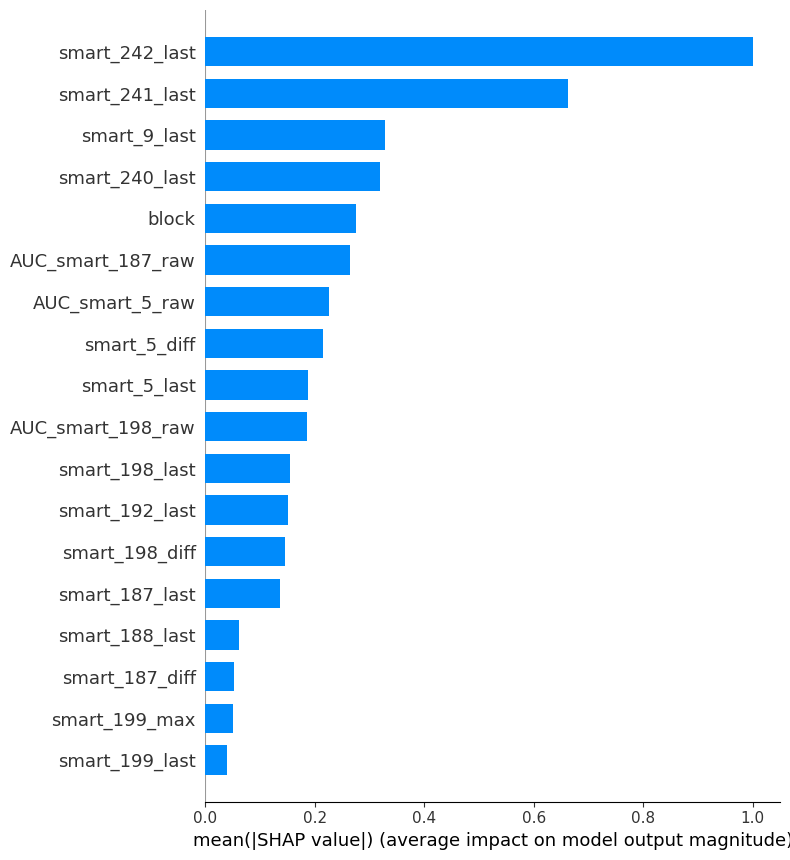


Обучение модели: XGBoost


XGBoost CV: 100%|██████████| 5/5 [00:00<00:00, 11.97it/s]


Вычисление SHAP для модели: XGBoost


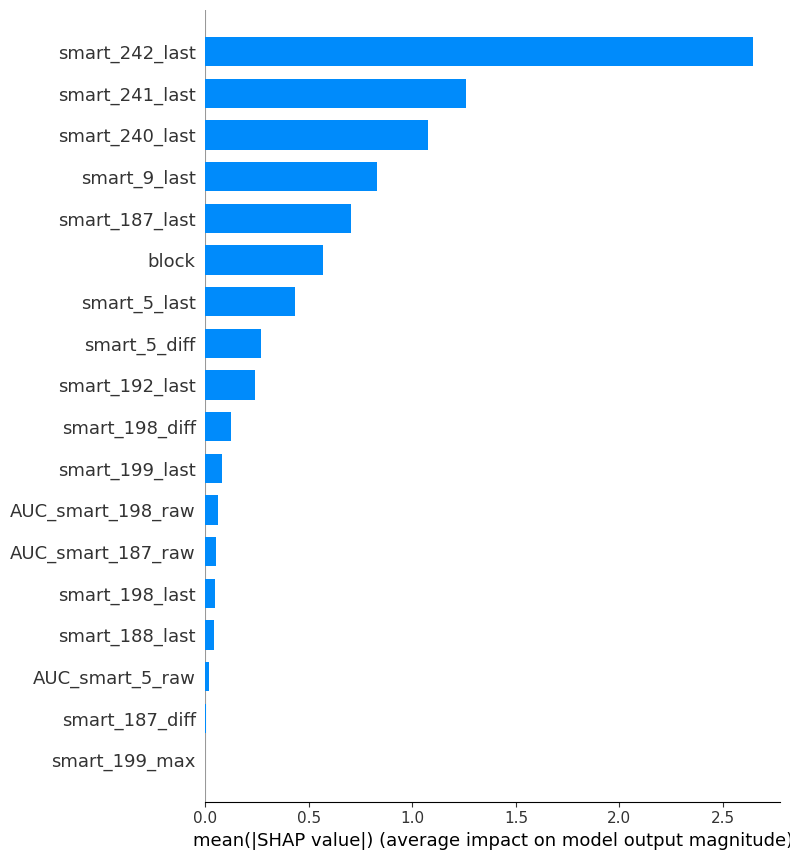


Результаты моделей:


,Model,ROC-AUC (CV),Precision (CV),Recall (CV),F1-Score (CV),ROC-AUC (Test),Precision (Test),Recall (Test),F1-Score (Test),ROC-AUC (Removed Data),Precision (Removed Data),Recall (Removed Data),F1-Score (Removed Data)
0,Logistic Regression,0.8744 ± 0.0489,0.6128 ± 0.0399,0.6955 ± 0.0765,0.6489 ± 0.0409,0.9629,0.7778,0.8235,0.8000,0.7206,0.0013,0.7243,0.0026
1,Random Forest,0.9678 ± 0.0048,0.8974 ± 0.0726,0.6763 ± 0.1066,0.7672 ± 0.0775,0.9900,1.0000,0.8235,0.9032,0.7781,0.0014,0.9676,0.0028
2,LightGBM,0.9651 ± 0.0122,0.8938 ± 0.0567,0.7684 ± 0.0659,0.8219 ± 0.0202,0.9478,0.8824,0.8824,0.8824,0.7754,0.0011,0.9784,0.0021
3,Extra Trees,0.9757 ± 0.0087,0.9193 ± 0.0554,0.7024 ± 0.0903,0.7918 ± 0.0529,0.9970,0.9375,0.8824,0.9091,0.8888,0.0013,0.9784,0.0026
4,CatBoost,0.9589 ± 0.0198,0.7687 ± 0.0759,0.7753 ± 0.0914,0.7664 ± 0.0480,0.9898,0.8421,0.9412,0.8889,0.8167,0.0011,0.9838,0.0023
5,XGBoost,0.9643 ± 0.0113,0.8290 ± 0.0877,0.7815 ± 0.0955,0.7959 ± 0.0308,0.9916,0.9412,0.9412,0.9412,0.7891,0.0011,0.9892,0.0022


In [14]:
# Определение моделей
models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()), 
        ('classifier', LogisticRegression(random_state=random_state, max_iter=1000, class_weight="balanced"))
    ]),
    "Random Forest": RandomForestClassifier(random_state=random_state, class_weight="balanced"),
    "LightGBM": LGBMClassifier(random_state=random_state, class_weight="balanced"),
    "Extra Trees": ExtraTreesClassifier(random_state=random_state, class_weight="balanced"),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=random_state, auto_class_weights="Balanced"),
    "XGBoost": XGBClassifier(
        eval_metric="logloss",
        random_state=random_state,
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    ),
}

# Определение кросс-валидации
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# Массив для хранения результатов метрик по каждой моделей
results = []

# Обучение для каждой модели
for model_name, model in models.items():
    print(f"\nОбучение модели: {model_name}")
    roc_auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    plt.figure(figsize=(12, 6))

    # Кросс-валидация
    for train_idx, val_idx in tqdm(cv.split(X_train, y_train), total=cv.get_n_splits(), desc=f"{model_name} CV"):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Обучение на реальных данных
        model.fit(X_fold_train, y_fold_train)

        # Оценка на валидационной выборке (реальные данные)
        y_val_pred = model.predict(X_fold_val)
        y_val_pred_proba = model.predict_proba(X_fold_val)[:, 1]

        roc_auc = roc_auc_score(y_fold_val, y_val_pred_proba)
        precision = precision_score(y_fold_val, y_val_pred)
        recall = recall_score(y_fold_val, y_val_pred)
        f1 = f1_score(y_fold_val, y_val_pred)

        roc_auc_scores.append(roc_auc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Сохранение средних значений метрик
    results.append({
        "Model": model_name,
        "ROC-AUC (CV)": f"{np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}",
        "Precision (CV)": f"{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}",
        "Recall (CV)": f"{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}",
        "F1-Score (CV)": f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
    })

    # Финальное тестирование на реальных данных
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    test_metrics = {
        "ROC-AUC (Test)": roc_auc_score(y_test, y_test_pred_proba),
        "Precision (Test)": precision_score(y_test, y_test_pred),
        "Recall (Test)": recall_score(y_test, y_test_pred),
        "F1-Score (Test)": f1_score(y_test, y_test_pred),
    }

    # Добавление тестовых метрик в финальные результаты
    results[-1].update({key: f"{value:.4f}" for key, value in test_metrics.items()})

    # Построение ROC и PR кривых
    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_pred_proba)

    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall_vals, precision_vals)

    plt.figure(figsize=(12, 6))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='b')
    plt.title(f'{model_name} - ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, label=f'AUC = {pr_auc:.2f}', color='g')
    plt.title(f'{model_name} - Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')

    # Сохранение графиков
    plt.suptitle(f'{model_name} - ROC and PR Curves')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"results/weighted/{model_name}_ROC_PR_Curves.png")
    plt.close()

    if model_name != "Logistic Regression":
        # Вычисление SHAP-значений
        print(f"Вычисление SHAP для модели: {model_name}")
        if model_name in ["Random Forest", "Extra Trees"]:
            explainer = shap.Explainer(model, X_train)
        elif model_name in ["LightGBM", "CatBoost", "XGBoost"]:
            explainer = shap.TreeExplainer(model)
        else:
            continue

        shap_values = explainer(X_test)

        # Визуализация SHAP для модели
        if len(shap_values.shape) == 3:  
            shap_values_class_1 = shap_values[..., 1]  
        else:
            shap_values_class_1 = shap_values 

        shap.summary_plot(shap_values_class_1, X_test, plot_type="bar")

    else:
        print(f"Вычисление SHAP для модели: {model_name}")
        
        if isinstance(model, Pipeline):
            base_model = model.named_steps['classifier']
            explainer = shap.Explainer(base_model, model.named_steps['scaler'].transform(X_train), feature_names=X_train.columns)

        shap_values = explainer(model.named_steps['scaler'].transform(X_test) if isinstance(model, Pipeline) else X_test)

        # Визуализация SHAP для модели
        shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)

    # Данные, которые модель не видела (проверим класс 0)
    y_test_pred = model.predict(removed_data_x_test)
    y_test_pred_proba = model.predict_proba(removed_data_x_test)[:, 1]

    test_metrics = {
        "ROC-AUC (Removed Data)": roc_auc_score(removed_data_y_test, y_test_pred_proba),
        "Precision (Removed Data)": precision_score(removed_data_y_test, y_test_pred),
        "Recall (Removed Data)": recall_score(removed_data_y_test, y_test_pred),
        "F1-Score (Removed Data)": f1_score(removed_data_y_test, y_test_pred),
    }

    # Добавление тестовых метрик в финальные результаты
    results[-1].update({key: f"{value:.4f}" for key, value in test_metrics.items()})

# Вывод таблицы результатов
results_df = pd.DataFrame(results)

print("\nРезультаты моделей:")
results_df

In [15]:
results_df.to_csv("results/models_results_weighted.csv", index=False)

## Выводим результаты

In [16]:
with open('results/models_results_resampled.csv') as f:
    res = pd.read_csv(f)

res

,Model,ROC-AUC (CV),Precision (CV),Recall (CV),F1-Score (CV),ROC-AUC (Test),Precision (Test),Recall (Test),F1-Score (Test),ROC-AUC (Removed Data),Precision (Removed Data),Recall (Removed Data),F1-Score (Removed Data)
0,Logistic Regression,0.8507 В± 0.0404,0.8105 В± 0.1213,0.6032 В± 0.0958,0.6790 В± 0.0614,0.9300,0.7500,0.7059,0.7273,0.7009,0.0012,0.6595,0.0025
1,Random Forest,0.9814 В± 0.0082,0.7528 В± 0.0251,0.8017 В± 0.0803,0.7740 В± 0.0357,0.9974,0.7727,1.0000,0.8718,0.7425,0.0010,0.9514,0.0021
2,Extra Trees,0.9823 В± 0.0066,0.7996 В± 0.0409,0.8413 В± 0.0480,0.8193 В± 0.0383,0.9993,0.7391,1.0000,0.8500,0.8008,0.0010,0.9459,0.0019
3,LightGBM,0.9770 В± 0.0112,0.8142 В± 0.0363,0.8409 В± 0.0683,0.8262 В± 0.0443,0.9933,0.7500,0.8824,0.8108,0.7448,0.0009,0.9243,0.0019
4,CatBoost,0.9742 В± 0.0107,0.8150 В± 0.0463,0.8080 В± 0.0771,0.8095 В± 0.0490,0.9944,0.6957,0.9412,0.8000,0.7758,0.0010,0.9351,0.0020
5,XGBoost,0.9700 В± 0.0159,0.8089 В± 0.0490,0.8409 В± 0.0775,0.8234 В± 0.0583,0.9968,0.7619,0.9412,0.8421,0.7755,0.0010,0.9297,0.0019


In [17]:
with open('results/models_results_weighted.csv') as f:
    res = pd.read_csv(f)

res

,Model,ROC-AUC (CV),Precision (CV),Recall (CV),F1-Score (CV),ROC-AUC (Test),Precision (Test),Recall (Test),F1-Score (Test),ROC-AUC (Removed Data),Precision (Removed Data),Recall (Removed Data),F1-Score (Removed Data)
0,Logistic Regression,0.8744 В± 0.0489,0.6128 В± 0.0399,0.6955 В± 0.0765,0.6489 В± 0.0409,0.9629,0.7778,0.8235,0.8000,0.7206,0.0013,0.7243,0.0026
1,Random Forest,0.9678 В± 0.0048,0.8974 В± 0.0726,0.6763 В± 0.1066,0.7672 В± 0.0775,0.9900,1.0000,0.8235,0.9032,0.7781,0.0014,0.9676,0.0028
2,LightGBM,0.9651 В± 0.0122,0.8938 В± 0.0567,0.7684 В± 0.0659,0.8219 В± 0.0202,0.9478,0.8824,0.8824,0.8824,0.7754,0.0011,0.9784,0.0021
3,Extra Trees,0.9757 В± 0.0087,0.9193 В± 0.0554,0.7024 В± 0.0903,0.7918 В± 0.0529,0.9970,0.9375,0.8824,0.9091,0.8888,0.0013,0.9784,0.0026
4,CatBoost,0.9589 В± 0.0198,0.7687 В± 0.0759,0.7753 В± 0.0914,0.7664 В± 0.0480,0.9898,0.8421,0.9412,0.8889,0.8167,0.0011,0.9838,0.0023
5,XGBoost,0.9643 В± 0.0113,0.8290 В± 0.0877,0.7815 В± 0.0955,0.7959 В± 0.0308,0.9916,0.9412,0.9412,0.9412,0.7891,0.0011,0.9892,0.0022
